<a href="https://colab.research.google.com/github/sriraj0926/Music-generation/blob/main/Deep_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Extracting data from the files

The audio files need to be loaded in order to analyse and train the model.
The audio files are of the type ".wav".

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
## Importing standard libraries and checking for GPU connection.

import torch
import torch.nn as nn
import torchaudio
import torchaudio.transforms
import torchaudio.io
import torch.optim
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import librosa
import librosa.display
print(torch.cuda.is_available())

from tqdm import tqdm

False


In [3]:
torch.manual_seed(42)

In [4]:
filepath = '/content/gdrive/MyDrive/kaggle/SynthwaveDatasest'
music_paths = [ os.path.join(filepath, wavfile) for wavfile in os.listdir(filepath) if wavfile.endswith('.wav')] ### A list containing all the file paths contained in the folder needs to be generated


In [5]:
music_data = []
sample_rate = 0
sr = 22050
for i in range(len(music_paths)):
  y, _ = librosa.load(music_paths[i], sr=sr, duration = 600)
  music_data.extend(y)
  sample_rate += 1

#[:30000000]
#duration = 600

In [ ]:
np.shape(music_data)

(79380000,)

##Data Analysis
Now that the data has been extracted as a list, we can now move on to the exploratory data analysis.

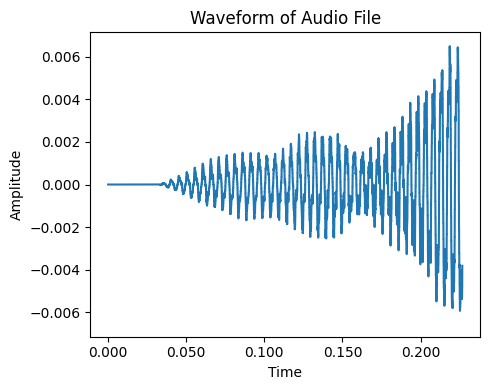

In [ ]:
#for i in range(len(sample_rate)):
    # Plot the waveform
plt.figure(figsize=(5, 4))
librosa.display.waveshow(np.array(music_data[:5000]), sr=sr)
plt.title(f"Waveform of Audio File")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()



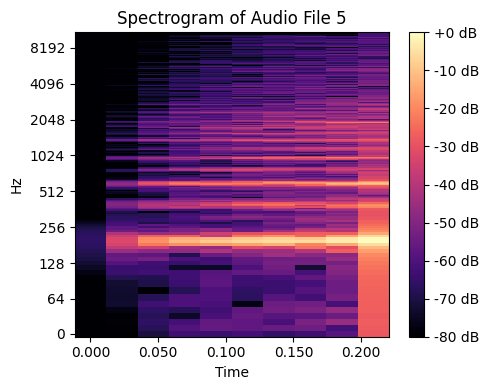

In [ ]:
#for i in range(len(sample_rate)):
plt.figure(figsize=(5, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(np.array(music_data[:5000]))), ref=np.max), y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Spectrogram of Audio File {i}")
plt.tight_layout()
plt.show()

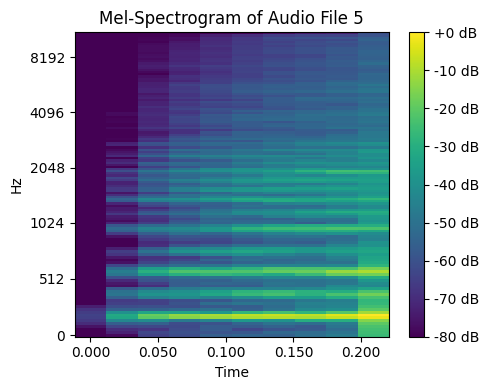

In [ ]:
#for i in range(len(sample_rate)):
mel_spectrogram = librosa.feature.melspectrogram(y=np.array(music_data[:5000]), sr=sr)
plt.figure(figsize=(5, 4))
librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max),
                            y_axis='mel', x_axis='time', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Mel-Spectrogram of Audio File {i}")
plt.tight_layout()
plt.show()


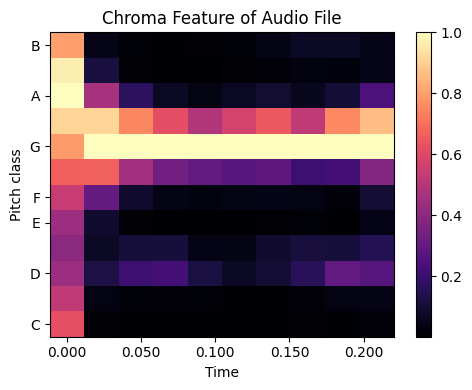

In [ ]:
#for i in range(len(sample_rate)):
chroma = librosa.feature.chroma_stft(y=np.array(music_data[:5000]), sr=sr)
plt.figure(figsize=(5, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title(f"Chroma Feature of Audio File")
plt.tight_layout()
plt.show()

In [ ]:
from collections import Counter

In [ ]:
def toChroma(music, sr):
  chroma_map = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
  estimated_keys = []
  j = 0
  for i in range(1, len(music), int(0.05*sr)):
    chromagram = librosa.feature.chroma_stft(y = music[j:i], sr = sr)
    mean_chroma = np.mean(chromagram, axis =1)
    estimated_key_index = np.argsort(mean_chroma)
    estimated_key = [chroma_map[estimated_key_index[0]], chroma_map[estimated_key_index[1]], chroma_map[estimated_key_index[2]], chroma_map[estimated_key_index[3]]]
    estimated_keys.extend(estimated_key)
    j += int(0.05*sr)
  return estimated_keys


notes = []
for i in range(len(sample_rate)):
  estimated_keys = toChroma(music_data[i], sample_rate[i])
  notes.extend(estimated_keys)
key_count = Counter(notes)
print(key_count)

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Counter({'G': 79299, 'G#': 79299, 'F#': 54319, 'F': 54319, 'A': 24980, 'A#': 24980, 'C': 125, 'C#': 125, 'D': 125, 'D#': 125})


Therefore, it can be seen that the most common notes are G, G#, F, F#, A and A#.

## Data preprocessing
Before feeding this into different neural networks, the data needs to be preprocessed.


All the files are first compiled and then split into X and y.

In [6]:
#spectrogram = []

#for i in range(sample_rate):
mel_spec = librosa.feature.melspectrogram(y = np.array(music_data), sr = sr, n_mels = 128)
db_mel_spec = librosa.power_to_db(mel_spec, ref = np.max)
#spectrogram.extend(mel_spec)
ref = np.max(db_mel_spec)
#spectrogram = np.array(db_mel_spec)
spec_max = np.max(db_mel_spec)
spec_min = np.min(db_mel_spec)
normalised_spec = (db_mel_spec - spec_min) / (spec_max - spec_min)
#normalised_spec = (normalised_spec * 2) - 1


In [7]:
seq_len = 256
X = []
y = []
for i in range(sample_rate):
  for j in range(0, len(normalised_spec[i])- seq_len, seq_len):
    X.append(normalised_spec[i][j : j + seq_len])
    y.append(normalised_spec[i][j + 1 : j + seq_len + 1])

X = np.array(X)
y = np.array(y)

In [8]:
print(X.shape)



(3630, 256)


In [9]:
del(normalised_spec)
del(music_paths)
del(music_data)
del(db_mel_spec)
del(mel_spec)

In [ ]:
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle = True)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15, shuffle = True)

In [ ]:
#print(X_train.shape)

(63, 410158)


In [10]:
train_size = 0.8
train_end = int(len(X) * train_size)


# Split the data
X_train, X_test = X[:train_end], X[train_end:]
y_train, y_test = y[:train_end], y[train_end:]


In [ ]:
print(X_train.shape[1], X_train.shape)

256 (2904, 256)


In [18]:
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))


train_loader = DataLoader(train_data, batch_size = 1, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 1, shuffle = False)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(X_train[0])

## Building the models-

A VAE with GRU is built.

In [ ]:
class VariationalAutoEncoder(nn.Module):
  def __init__(self, inp, hidden = 512, z = 256):
    super().__init__()

    self.mu = nn.Linear(hidden, z)
    self.sigma = nn.Linear(hidden, z)

    #self.z2h = nn.Linear(z, hidden)
    self.out = nn.GRU(input_size = hidden, hidden_size = inp, num_layers = 5, batch_first = True)#nn.Linear(hidden, inp)

    self.enc = nn.Sequential(
        #nn.Linear(inp, hidden),
        #nn.ReLU(),
        #nn.Linear(150, 100),
        #nn.ReLU(),
        #nn.Linear(100, hidden)
        nn.GRU(input_size = inp, hidden_size = hidden, num_layers = 5, batch_first = True)
    )

    self.dec = nn.Sequential(
        nn.Linear(z, hidden),
        #nn.ReLU(),
        #nn.Linear(64, 100),
        nn.ReLU(),
        #nn.Linear(100, 150),
        #nn.ReLU(),
        #nn.GRU(input_size = hidden, hidden_size = hidden, num_layers = 4, batch_first = True)
    )



  def encoder(self, x):
    hid_op, _ = self.enc(x)
    mu, sigma = self.mu(hid_op), self.sigma(hid_op)
    return mu, sigma

  def decoder(self, z):
    hid_op = self.dec(z)
    return torch.sigmoid(self.out(hid_op)[0])

  def forward(self, x):
    mu, sigma = self.encoder(x)
    epsilon = torch.randn_like(sigma)
    z_repar = mu + sigma*epsilon
    x_recon = self.decoder(z_repar)
    return x_recon, mu, sigma




In [ ]:
inp = X.shape[1]
del(X)
del(y)

In [ ]:
model = VariationalAutoEncoder(inp)
optimiser = torch.optim.Adam(model.parameters(), lr = 3e-6)
#scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=10, gamma=0.2)
loss = nn.MSELoss()
num_epochs = 5

for epoch in range(num_epochs):
  loop = tqdm(enumerate(train_loader))

  for i,(x, _) in loop:
    x = x.to(device)
    x_recon, mu, sigma = model(x)
    x_recon_norm = (x_recon- x_recon.min())/(x_recon.max()- x_recon.min())
    #x_recon_norm = (x_recon_norm * 2) - 1
    recon_loss = loss(x_recon_norm, x)
    kl = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
    comb_loss = recon_loss + kl
    optimiser.zero_grad()
    comb_loss.backward()
    optimiser.step()

    #scheduler.step()
    loop.set_postfix(loss = comb_loss.item())
    del(x)
    del(x_recon)
    del(comb_loss)
    del(kl)
    del(recon_loss)

23it [01:56,  5.07s/it, loss=1.1]
23it [01:59,  5.20s/it, loss=0.826]
23it [01:54,  4.99s/it, loss=0.637]
23it [01:57,  5.11s/it, loss=0.517]
23it [01:48,  4.71s/it, loss=0.466]


In [ ]:
model.eval()
#test_recon_loss = 0
#test_kl_loss = 0
comb_test_loss = 0
with torch.no_grad():
  for epoch in range(num_epochs):
    loop = tqdm(enumerate(test_loader))

    for i, (x, _) in loop:
        x = x.to(device)
        x_recon, mu, sigma = model(x)
        x_recon_norm = (x_recon - x_recon.min()) / (x_recon.max() - x_recon.min())
        recon_loss = loss(x_recon_norm, x)
        kl = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
        comb_test_loss = kl + recon_loss
        loop.set_postfix(loss = comb_test_loss.item())
        del(x)
        del(x_recon)
        del(comb_test_loss)
        del(kl)
        del(recon_loss)
        #test_recon_loss += recon_loss.item()
        #test_kl_loss += kl.item()

#test_recon_loss /= len(test_loader)
#test_kl_loss /= len(test_loader)
#test_loss = test_recon_loss + test_kl_loss



6it [00:02,  2.03it/s, loss=0.485]
6it [00:02,  2.03it/s, loss=0.485]
6it [00:03,  1.82it/s, loss=0.485]
6it [00:03,  1.77it/s, loss=0.485]
6it [00:02,  2.03it/s, loss=0.485]


In [ ]:
torch.save(model.state_dict(),'/content/gdrive/MyDrive/kaggle/Models/GRUVAE_ver10.pth')
#del(model)

In [ ]:
import soundfile as sf

inference = VariationalAutoEncoder(2048)
inference.load_state_dict(torch.load('/content/gdrive/MyDrive/kaggle/Models/GRUVAE_ver10.pth'))
inference.eval()

latent_code = torch.rand(6000, 512)

with torch.no_grad():
    norm_generated_spec = inference.decoder(latent_code)
    #del(inference)
    norm_generated_spec = np.array(norm_generated_spec.detach())

#norm_generated_spec = (norm_generated_spec + 1) * 0.5
generated_spec = np.array((norm_generated_spec * (spec_max - spec_min))+ spec_min)
generated_spec = librosa.db_to_power(generated_spec, ref = ref)



In [ ]:
generated_audio = librosa.feature.inverse.mel_to_audio(generated_spec, sr = sr, n_iter = 100)

/usr/local/lib/python3.10/dist-packages/librosa/feature/inverse.py:99: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(


In [ ]:
sf.write('/content/gdrive/MyDrive/kaggle/GeneratedSamples/GRUVAE_ver10_samp02.mp3', generated_audio, sr)

In [ ]:
#chroma = librosa.feature.chroma_stft(y=generated_spec, sr=sr)
#plt.figure(figsize=(5, 4))
#librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
#plt.colorbar()
#plt.title("Chroma Feature of Audio File")
#plt.tight_layout()
#plt.show()

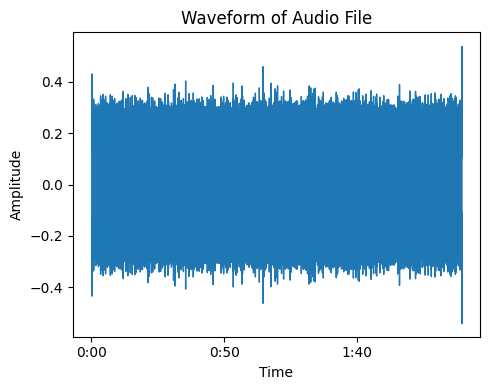

In [ ]:


plt.figure(figsize=(5, 4))
librosa.display.waveshow(generated_audio, sr=sr)
plt.title(f"Waveform of Audio File")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

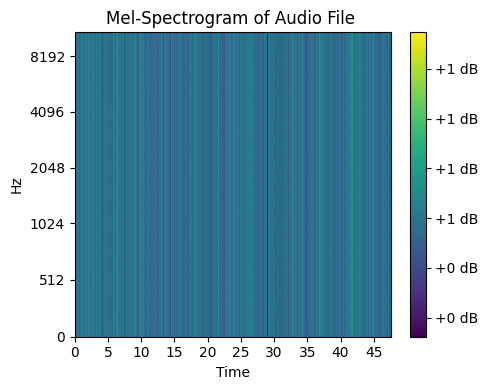

In [ ]:
#mel_spectrogram = librosa.feature.melspectrogram(y=music_data[i], sr=sample_rate[i])
plt.figure(figsize=(5, 4))
librosa.display.specshow(generated_spec,y_axis='mel', x_axis='time', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Mel-Spectrogram of Audio File ")
plt.tight_layout()
plt.show()

In [ ]:
#generated_spec = librosa.db_to_amplitude(generated_spec)
#generated_spec = np.array(generated_spec)
# Invert the spectrogram to audio
#print(generated_spec.T.shape[0])
#for i in range(300):
    #audio_slice = librosa.feature.inverse.mel_to_audio(generated_spec.T[i], sr=sample_rate, n_mels = 512)
    #generated_audio.append(audio_slice)

#generated_audio = np.concatenate(generated_audio, axis=0)

# Save the generated audio

In [13]:
class UnFlatten(nn.Module):
    def forward(self, input, size=512):
        return input.view(1, size, input.size(0))

In [58]:
class ConvVAE(nn.Module):

  def __init__(self, inp, hidden = 512, z = 128):
    super().__init__()
    self.inp = inp
    self.z = z
    self.hidden = hidden
    self.HigherDim = nn.Linear(self.z, self.hidden)
    self.mu = nn.Linear(hidden, z)
    self.sigma = nn.Linear(hidden, z)

    self.EncoderLayer = nn.Sequential(

        nn.Conv1d(self.inp, 32, kernel_size = 3),
        #nn.BatchNorm1d(32),
        nn.ReLU(),
        #nn.LeakyReLU(0.2),
        nn.Conv1d(32, 64, kernel_size = 3),
        #nn.BatchNorm1d(64),
        nn.ReLU(),
        #nn.LeakyReLU(0.2),
        nn.Conv1d(64, 128, kernel_size = 3),
        #nn.BatchNorm1d(128),
        nn.ReLU(),
        #nn.LeakyReLU(0.2),
        nn.Conv1d(128, 256, kernel_size = 3),
        #nn.BatchNorm1d(256),
        nn.ReLU(),
        #nn.LeakyReLU(0.2),
        nn.Conv1d(256, 512, kernel_size = 3),
        #nn.BatchNorm1d(512),
        #nn.ReLU(),
        ##nn.Conv1d(512, self.hidden, kernel_size = 3),
        #nn.BatchNorm1d(self.hidden),
        #nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Flatten()
    )

    self.DecoderLayer = nn.Sequential(
        UnFlatten(),
        #nn.Linear(self.z, self.hidden),
        #nn.ConvTranspose1d(self.hidden, 512, kernel_size = 3),
        #nn.BatchNorm1d(512),
        #nn.LeakyReLU(0.2),
        nn.ReLU(),
        nn.ConvTranspose1d(512, 256, kernel_size = 3),
        #nn.BatchNorm1d(256),
        #nn.LeakyReLU(0.2),
        nn.ReLU(),
        nn.ConvTranspose1d(256, 128, kernel_size = 3),
        #nn.BatchNorm1d(128),
        nn.ReLU(),
        #nn.LeakyReLU(0.2),
        nn.ConvTranspose1d(128, 64, kernel_size = 3),
        #nn.BatchNorm1d(64),
        nn.ReLU(),
        #nn.LeakyReLU(0.2),
        nn.ConvTranspose1d(64, 32, kernel_size = 3),
        #nn.BatchNorm1d(32),
        nn.ReLU(),
        nn.ConvTranspose1d(32, inp, kernel_size = 3),
        #nn.BatchNorm1d(self.inp),
        #nn.LeakyReLU(0.2),
        nn.ReLU(),
        nn.Flatten()
    )

  def Encoder(self, inp):
    op1 = self.EncoderLayer(inp)
    mu, sigma = self.mu(op1.T), self.sigma(op1.T)
    return mu, sigma

  def Decoder(self, z):
    z = self.HigherDim(z)
    op = self.DecoderLayer(z)
    return nn.functional.hardtanh(op)

  def forward(self, inp):
    mu, sigma = self.Encoder(inp)
    epsilon = torch.randn_like(sigma)
    z_repar = mu + sigma * epsilon
    x_recon = self.Decoder(z_repar)
    return x_recon, mu, sigma






In [59]:
model = ConvVAE(1)
model.to(device)
optimiser = torch.optim.SGD(model.parameters(), lr = 9e-7, momentum = 0.8)
#scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=10, gamma=0.2)
loss = nn.MSELoss()
num_epochs = 50

for epoch in range(num_epochs):
  loop = tqdm(enumerate(train_loader))

  for i,(x, _) in loop:
    x = x.to(device)
    x_recon, mu, sigma = model(x)
    #x_recon_norm = (x_recon - x_recon.min()) / (x_recon.max()- x_recon.min()).to(device)
    #x_recon_norm = (x_recon_norm * 2) - 1
    recon_loss = loss(x_recon, x).to(device)
    kl = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
    comb_loss = recon_loss + kl
    optimiser.zero_grad()
    comb_loss.backward()
    optimiser.step()
    #torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
    #scheduler.step()
    loop.set_postfix(loss = comb_loss.item())
    del(x)
    del(x_recon)
    del(comb_loss)
    del(kl)
    del(recon_loss)

994it [01:02, 15.93it/s, loss=2.12]


KeyboardInterrupt: 

In [ ]:
model.eval()
#test_recon_loss = 0
#test_kl_loss = 0
comb_test_loss = 0
with torch.no_grad():
  for epoch in range(num_epochs):
    loop = tqdm(enumerate(test_loader))

    for i, (x, _) in loop:
        x = x.to(device)
        x_recon, mu, sigma = model(x)
        x_recon_norm = (x_recon - x_recon.min()) / (x_recon.max() - x_recon.min())
        recon_loss = loss(x_recon_norm, x)
        kl = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
        comb_test_loss = kl + recon_loss
        loop.set_postfix(loss = comb_test_loss.item())
        del(x)
        del(x_recon)
        del(comb_test_loss)
        del(kl)
        del(recon_loss)
        #test_recon_loss += recon_loss.item()
        #test_kl_loss += kl.item()

#test_recon_loss /= len(test_loader)
#test_kl_loss /= len(test_loader)
#test_loss = test_recon_loss + test_kl_loss



726it [00:16, 45.37it/s, loss=1]
726it [00:15, 45.49it/s, loss=1]
726it [00:15, 45.71it/s, loss=1]
726it [00:16, 45.27it/s, loss=1]
726it [00:16, 43.17it/s, loss=1]


In [ ]:
torch.save(model.state_dict(),'/content/gdrive/MyDrive/kaggle/Models/ConvVAE_ver02.pth')
#del(model)

In [ ]:
import soundfile as sf

inference = ConvVAE(1)
inference.load_state_dict(torch.load('/content/gdrive/MyDrive/kaggle/Models/ConvVAE_ver02.pth'))
inference.eval()

latent_code = torch.rand(1000, 128)

with torch.no_grad():
    norm_generated_spec = inference.Decoder(latent_code)
    #del(inference)
    norm_generated_spec = np.array(norm_generated_spec.detach())

#norm_generated_spec = (norm_generated_spec + 1) * 0.5
generated_spec = np.array((norm_generated_spec * (spec_max - spec_min))+ spec_min)
generated_spec = librosa.db_to_power(generated_spec, ref = 20)



In [ ]:
generated_audio = librosa.feature.inverse.mel_to_audio(generated_spec, sr = sr, n_iter = 20)

In [ ]:
sf.write('/content/gdrive/MyDrive/kaggle/GeneratedSamples/ConvVAE_ver02_samp04.mp3', generated_audio, sr)

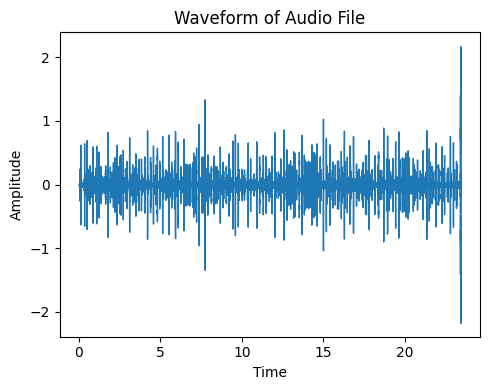

In [ ]:
plt.figure(figsize=(5, 4))
librosa.display.waveshow(generated_audio, sr=sr)
plt.title(f"Waveform of Audio File")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

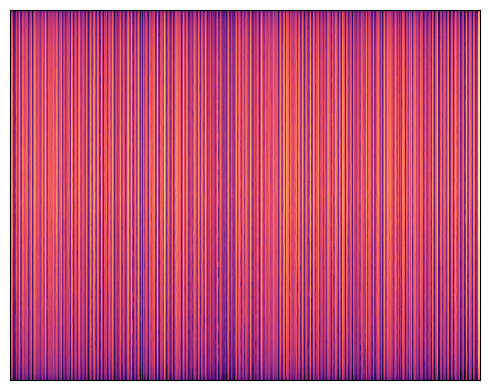

In [ ]:
#mel_spectrogram = librosa.feature.melspectrogram(y=music_data[i], sr=sample_rate[i])
plt.figure(figsize=(5, 4))
mel_spec  = librosa.feature.melspectrogram(y = generated_audio, sr = sr)
librosa.display.specshow(librosa.power_to_db(mel_spec, ref = np.max))
#plt.colorbar(format='%+2.0f dB')
#plt.title(f"Mel-Spectrogram of Audio File ")
plt.tight_layout()
plt.show()

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, x, output):
    super(),__init__()
